# QAOA Weighted MAXSAT

Gahwon Lee, Andrew Tan

In [1]:
import qiskit
import numpy as np
import random as rand
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Introduction

### Weighted MAXSAT (3-SAT)

Given a boolean formula in conjunctive normal form as well as weights to each of those clauses, find the set of boolean variables that maximize the weights. For example, if a clause with weight 3 is true, then add 3 to the total weight. Each clause can contain exactly three boolean variables.

### QAOA

Quantum Approximation Optimization Algorithm is designed to approximate the Quantum Adiabatic Algorithm by splitting up different time slices into separate gates. Since it approximates the QAA, as the number of gates increases to infinity, the QAOA result will also increase to the ideal state.

## Methods

### Encoding Qubits

The bitstring corresponding to the output of QAOA will be the input qubits. Each qubit will either be 1 for true or 0 for false. 

### Cost and Driver Hamiltonians *C* and *B*

(3-SAT) $C = \sum_{m=0}^M I-\frac{1}{2}((I_1 \pm Z_1)\otimes (I_2 \pm Z_2)\otimes (I_3 \pm Z_3))$

(2-SAT) $C = \sum_{m=0}^M I-\frac{1}{2}((I_1 \pm Z_1)\otimes (I_2 \pm Z_2))$

$B = \sum_{k=0}^{n-1} X_k$

### Driver Gate W

$W(\beta) = \prod_{k=0}^{n-1}H_k \prod_{k=1}^{n-1}C_{k,0}^{X}    U_{0}(2\beta) \prod_{k=1}^{n-1}C_{k,0}^{X} \prod_{k=0}^{n-1}H_k$

In [2]:
def ref_gate(n, qc, q, beta):
    # W gate
    for i in range(0,n):
        qc.h(q[i])
    for i in range(1,n):
        qc.cx(q[i],q[0])
        
    # apply phase gate
    qc.u1(2*beta, q[0])
    
    for i in range(n-1,0,-1):
        qc.cx(q[i],q[0])
    for i in range(0,n):
        qc.h(q[i])

### Cost Gate V

$V(\gamma) = C_{x,y} U_{y}(\pm\gamma weight) C_{x,y} U_{x}(\pm\gamma weight) U_{y}(\pm\gamma weight)$

In [4]:
def constraint_gate(n, qc, q, gamma, clauses):
    # V gate
    # 2-SAT
    
    # clause[0] is the weight
    # clauses will be in form clauses[i] = [-1*x,y] with x and y refering to the qubits we act on, and a negative value
    # means a NOT-x
    # clauses are also 1-indexed, so be sure to subtract by 1 before reading them!
    for clause in clauses:
        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        
        
        flip = 2*(x_not == y_not) - 1 # flips if x_not xor y_not
        qc.cx(q[x],q[y])
        qc.u1(flip*-1*gamma*weight,q[y])
        qc.cx(q[x],q[y])

        flip = -(2*(x_not)-1) # x
        qc.u1(flip*-1*gamma*weight,q[x])

        flip = -(2*(y_not)-1) # y
        qc.u1(flip*-1*gamma*weight,q[y])

### Classic Solver

In [5]:
def classic(clauses, value):
    value = value[::-1]
    res = 0
    
    for clause in clauses:
        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        
        result = ((value[x] == '1') != x_not) or ((value[y] == '1') != y_not)
        if (result):
            res += weight
            
    return res

### Calculating the Expectation
Expectation = $\langle \gamma,\beta\left|C\right|\gamma,\beta\rangle$

In [6]:
def run_qaoa(qc,q,c,n,gamma,beta,clauses):
    for i in range(n):
        qc.h(q[i])
    p = 1
    for pp in range(p):
        constraint_gate(n, qc, q, gamma, clauses)
        ref_gate(n, qc, q, beta)

def expectation(gamma, beta, clauses):
    
    n = 3
    q = qiskit.QuantumRegister(n)
    c = qiskit.ClassicalRegister(n)
    qc = qiskit.QuantumCircuit(q,c)
    # q[0..n-1] are input qubits
    
    run_qaoa(qc,q,c,n,gamma,beta,clauses)
    
    qc.measure(q, c)
    
    repetitions = 1024
    job = qiskit.execute(qc, backend='local_qasm_simulator', shots=repetitions)
    result = job.result().get_counts(qc)
    
    answer = 0
    for key in result.keys():
        probability = result[key] / repetitions
        answer += probability * classic(clauses, key)
        
    #print("Resulting bitstring after 1024 shot: "+str(result))

    return answer
    
print("Expectation: "+str(expectation(math.pi/6,math.pi/2, [[1,1,2],[2,-1,-2],[1,-1,2],[2,1,-2]])))

Expectation: 4.4990234375


### Classically Optimizing *γ* and *β*

Randomly pick γ and β and find the best input bitstring.

We chose this method over gradient descent because there are several local maximums for our cost function.

In [6]:
cnf = [[1,1,3],[1,-1,-2],[1,1,-3],[1,-3,2]]
max = 0
best_bitstring = ""
for i in range(8):
    beta = rand.uniform(0,math.pi)
    gamma = rand.uniform(0,math.pi/2)
    print("Expectation: "+str(expectation(gamma,beta,cnf)))
    
    n = 3
    q = qiskit.QuantumRegister(n)
    c = qiskit.ClassicalRegister(n)
    qc = qiskit.QuantumCircuit(q,c)
    
    run_qaoa(qc,q,c,n,gamma,beta,cnf)
    qc.measure(q,c)
    job = qiskit.execute(qc, backend='local_qasm_simulator', shots=1)
    result = job.result().get_counts(qc)
    print("Resulting bitstring after 1 shot: "+str(result))
    cost = classic(cnf,next(iter(result.keys())))
    if max < cost:
        max = cost
        best_bitstring = next(iter(result.keys()))
    print("Cost of this bitstring(big is better): "+str(cost))
    
print("And the best bitstring is "+ best_bitstring+" with a cost of "+str(max))

Expectation: 2.8876953125
Resulting bitstring after 1 shot: {'101': 1}
Cost of this bitstring(big is better): 3
Expectation: 3.03125
Resulting bitstring after 1 shot: {'001': 1}
Cost of this bitstring(big is better): 4
Expectation: 2.7783203125
Resulting bitstring after 1 shot: {'000': 1}
Cost of this bitstring(big is better): 3
Expectation: 2.763671875
Resulting bitstring after 1 shot: {'100': 1}
Cost of this bitstring(big is better): 2
Expectation: 3.0458984375
Resulting bitstring after 1 shot: {'000': 1}
Cost of this bitstring(big is better): 3
Expectation: 3.0087890625
Resulting bitstring after 1 shot: {'000': 1}
Cost of this bitstring(big is better): 3
Expectation: 3.140625
Resulting bitstring after 1 shot: {'011': 1}
Cost of this bitstring(big is better): 3
Expectation: 2.8349609375
Resulting bitstring after 1 shot: {'000': 1}
Cost of this bitstring(big is better): 3
And the best bitstring is 001 with a cost of 4


### Plotting
We kept the $\beta$ value constant

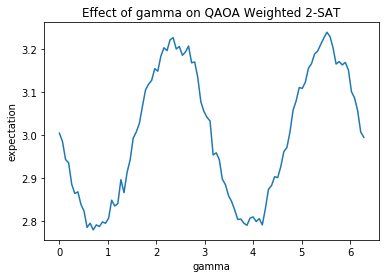

In [20]:
g = np.linspace(0, 2 * math.pi, 100)
b = 5 * math.pi / 6
'''cnf = [[1,1,2],[1,-1,2],[1,1,-2],[1,-1,-2],
       [1,1,3],[1,-1,3],[2,1,-3],[3,-1,-3],
       [1,2,3],[2,-2,3],[1,2,-3],[2,-2,-3]]'''
cnf = [[1,1,3],[1,-1,-2],[1,1,-3],[1,-3,2]]

# clause format is [weight,1st var, 2nd var]
def f(x):
    return expectation(x, b, cnf)

plt.plot(g, np.array([f(x) for x in g]))
plt.xlabel('gamma')
plt.ylabel('expectation')
plt.title('Effect of gamma on QAOA Weighted 2-SAT')
plt.show()

NameError: name 'ptl' is not defined

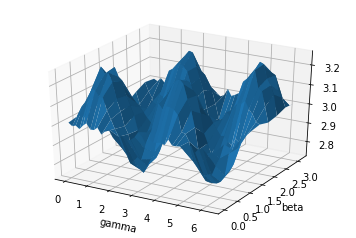

In [21]:
g = np.linspace(0, 2 * math.pi, 40)
b = np.linspace(0, math.pi, 10)
gamma, beta = np.meshgrid(g, b)
cnf = [[1,1,3],[1,-1,-2],[1,1,-3],[1,-3,2]]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(gamma, beta, np.array([expectation(x, y, cnf) for x,y in zip(np.ravel(gamma), np.ravel(beta))]).reshape(gamma.shape))

plt.xlabel('gamma')
plt.ylabel('beta')

plt.title('Effect of gamma on QAOA Weighted 2-SAT')
plt.show()

## Results and Discussion

As you can see the 2D and 3D graphs above, our simple 2SAT problem has some very stable curves. Be warned, these graphs take several minutes to create.

Our classical optimization algorithm almost always gets the correct value, but that is because we iterate 8 times.

## Conclusion

### Was QAOA effective in finding decent solutions?

Yes, but by the nature of 2SAT, any bitstring would have been a decent solution.

### What % of the optimum solution did QAOA achieve?

QAOA constantly got very close to the optimal solution with a depth of 1. However, this is likely due to the fact that our functions were extremely simple and trivial to solve. Our functions were simple because the computer could not efficiently simulate a quantum computer for more than a few qubits.

### Does the technique have any issues?

Calculating the Expectation value takes ages because we have to run multiple shots, and for each of those shots we have to evaluate the bitstring pertaining to that shot classically. Because there's so many shots, there is likely to be 2^n classical evaluations, destroying the optimization part of this algorithm.

### Weighted 3SAT

In [7]:
### Weighted 3SAT
def constraint_3sat(n, qc, q, gamma, clauses):
    for clause in clauses:

        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        z = abs(clause[3]) - 1
        z_not = clause[3] < 0

        flip = 2*((x_not+y_not+z_not)%2 == 0) - 1
        qc.cx(q[z],q[x])
        qc.cx(q[y],q[x])
        qc.u1(flip*-1 * gamma * weight,q[x])
        qc.cx(q[y],q[x])
        qc.cx(q[z],q[x])

        flip = 2*(z_not == y_not) - 1 # flips if z_not xor y_not
        qc.cx(q[y],q[z])
        qc.u1(flip * -1 * gamma * weight,q[z])
        qc.cx(q[y],q[z])

        flip = 2*(x_not == y_not) - 1 # flips if x_not xor y_not
        qc.cx(q[y],q[x])
        qc.u1(flip * -1 * gamma * weight,q[x])
        qc.cx(q[y],q[x])

        flip = 2*(x_not == z_not) - 1 # flips if z_not xor x_not
        qc.cx(q[z],q[x])
        qc.u1(flip * -1 * gamma * weight,q[x])
        qc.cx(q[z],q[x])

        flip = -(2*(x_not)-1) # x
        qc.u1(flip*-1*gamma*weight,q[x])

        flip = -(2*(y_not)-1) # y
        qc.u1(flip*-1*gamma*weight,q[y])

        flip = -(2*(z_not)-1) # z
        qc.u1(flip*-1*gamma*weight,q[z])


### Classic 3SAT Verifier

In [8]:
def classic_3sat(clauses, value):
    value = value[::-1]
    res = 0
    
    for clause in clauses:
        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        z = abs(clause[3]) - 1
        z_not = clause[3] < 0
        
        result = ((value[x] == '1') != x_not) or ((value[y] == '1') != y_not) or ((value[z] == '1') != z_not)
        if (result):
            res += weight
            
    return res

### Functions to run QAOA and calculate the Expectation value

In [9]:
def run_qaoa_3sat(qc,q,c,n,gamma,beta,clauses):
   
    constraint_3sat(n, qc, q, gamma, clauses)
    ref_gate(n, qc, q, beta)

def expectation_3sat(n, gamma, beta, prev_gamma, prev_beta, clauses):
    
    q = qiskit.QuantumRegister(n)    # q[0..n-1] are input qubits (they're all input qubits)
    c = qiskit.ClassicalRegister(n)
    qc = qiskit.QuantumCircuit(q,c)
    for i in range(n):
        # Apply the hadamards to the qubits
        qc.h(q[i])
        
    for i in range(len(prev_gamma)):
        # Apply every previous iteration's (beta, gamma) value
        run_qaoa_3sat(qc,q,c,n,prev_gamma[i],prev_beta[i],clauses)

    run_qaoa_3sat(qc,q,c,n,gamma,beta,clauses)
    qc.measure(q, c)

    repetitions = 1024
    job = qiskit.execute(qc, backend='local_qasm_simulator', shots=repetitions)
    result = job.result().get_counts(qc)

    answer = 0
    for key in result.keys():
        probability = result[key] / repetitions
        answer += probability * classic_3sat(clauses, key)

    #print("Resulting bitstring after 1024 shot: "+str(result))

    return answer
#print("Expectation: "+str(expectation(math.pi/6,math.pi/2, [[1,1,2,3],[2,1,-2,3],[1,-1,2,4],[2,1,-2,3]])))

### Running QAOA for 3SAT

In [12]:
#cnf = [[1,1,2,3],[2,1,2,-3],[1,1,-2,3],[3,1,-2,-3],[2,-1,2,3],[1,-1,2,-3],[1,-1,-2,3],[1,-1,-2,-3]]
cnf = [[1,4,3,5],[1,-4,-5,-1],[1,5,-2,-6],[1,-4,-5,-2],[1,1,3,-5],[1,-4,-3,1],[1,5,-3,4],[1,-1,2,-4],[1,-2,6,5],[1,-3,-6,-2],[1,-3,1,-6],[1,-3,-4,1],[1,4,1,5],[1,3,-4,-1],[1,-1,5,-2],[1,2,-6,-3],[1,6,3,1],[1,-2,5,3],[1,1,-6,5],[1,-5,-6,-3],[1,1,2,-5],[1,3,-1,-4],[1,-3,2,-5],[1,5,6,-4],[1,6,3,-5],[1,-2,-1,3],[1,2,1,6],[1,-1,-5,2],[1,-4,1,3],[1,4,-6,-2],[1,-1,3,6],[1,5,-6,3],[1,-6,1,-4],[1,-4,1,5],[1,-3,6,-1],[1,-5,-2,1],[1,1,6,5],[1,-3,5,2],[1,-4,5,2],[1,5,-1,3],[1,-2,6,5],[1,3,4,5],[1,-6,3,1],[1,4,-1,5],[1,-4,6,-2],[1,-6,5,3],[1,3,-2,-1],[1,-6,-5,-2],[1,4,6,2],[1,-5,4,3],[1,3,4,-5],[1,4,5,-6],[1,-3,-6,-2],[1,5,-4,3],[1,1,-4,-3],[1,2,5,-4],[1,4,5,-2],[1,-3,-1,5],[1,-5,6,-2],[1,-1,-5,-6],]
max = 0
best_bitstring = ""
n = 6
depth = 4
best_expectation = []
best_gamma = []
best_beta = []
for p in range(depth):
    best_expectation.append(0)
    best_gamma.append(0)
    best_beta.append(0)
    average = 0
    for i in range(4):

        beta = rand.uniform(0,math.pi)
        gamma = rand.uniform(0,math.pi/2)
        expectation = expectation_3sat(n,gamma,beta,best_gamma,best_beta,cnf)
        print("Expectation: "+str(expectation))
        if expectation > best_expectation[p]:
            best_gamma[p] = gamma
            best_beta[p] = beta
            best_expectation[p] = expectation
        average += expectation
        '''
        q = qiskit.QuantumRegister(n)
        c = qiskit.ClassicalRegister(n)
        qc = qiskit.QuantumCircuit(q,c)

        run_qaoa_3sat(qc,q,c,n,gamma,beta,cnf)
        qc.measure(q,c)
        job = qiskit.execute(qc, backend='local_qasm_simulator', shots=1)
        result = job.result().get_counts(qc)
        print("Resulting bitstring after 1 shot: "+str(result))
        cost = classic(cnf,next(iter(result.keys())))
        if max < cost:
            max = cost
            best_bitstring = next(iter(result.keys()))
        print("Cost of this bitstring(big is better): "+str(cost))
        '''
    average = average/4
    print("p="+str(p)+": (gamma,beta): ("+str(best_gamma[p])+","+str(best_beta[p])+") | expectation: "+str(best_expectation[p])+"| average: "+str(average))
#print("Best Bitstring is "+ best_bitstring+" | Cost: "+str(max))



Expectation: 52.7041015625
Expectation: 52.5400390625
Expectation: 52.8671875
Expectation: 52.7548828125
p=0: (gamma,beta): (0.38628303351868654,0.7424568557671304) | expectation: 52.8671875| average: 26.3582763671875
Expectation: 52.98828125
Expectation: 52.544921875
Expectation: 51.9921875
Expectation: 52.3525390625
p=1: (gamma,beta): (0.20753741471450632,1.4786841374256412) | expectation: 52.98828125| average: 26.2347412109375
Expectation: 52.8076171875
Expectation: 52.44140625
Expectation: 52.732421875
Expectation: 52.6025390625
p=2: (gamma,beta): (0.5352785831603226,0.060409567437957425) | expectation: 52.8076171875| average: 26.322998046875
Expectation: 52.55078125
Expectation: 51.98828125
Expectation: 51.79296875
Expectation: 52.40625
p=3: (gamma,beta): (1.0768557541326742,2.6186703188019553) | expectation: 52.55078125| average: 26.09228515625


### Graph 3SAT

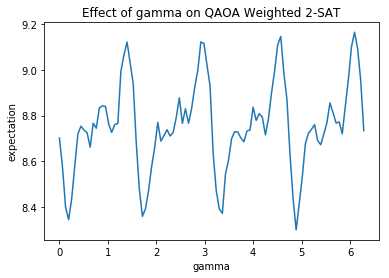

In [18]:
g = np.linspace(0, 2 * math.pi, 100)
b = 5 * math.pi / 6
#cnf = [[1,1,2,3],[2,1,2,-3],[1,1,-2,3],[3,1,-2,-3],[2,-1,2,3],[1,-1,2,-3],[1,-1,-2,3],[1,-1,-2,-3]]
cnf = [[1,-5,3,-1],[1,4,3,-1],[1,2,-1,-5],[1,5,-3,-6],[1,1,3,4],
       [1,-2,5,6],[1,3,-6,-5],[1,4,-2,-6],[1,-1,-2,5],[1,1,-3,-4]]
# clause format is [weight,1st var, 2nd var]
def f(x):
    return expectation_3sat(6, x, b, cnf)

plt.plot(g, np.array([f(x) for x in g]))
plt.xlabel('gamma')
plt.ylabel('expectation')
plt.title('Effect of gamma on QAOA Weighted 2-SAT')
plt.show()